读取每个簇的papers

In [2]:
import json

# 读取 JSON 文件
with open("../output_data/jsonCluster_All_Coop10.json", "r", encoding="utf-8") as f:
    jsonData = json.load(f)  # 解析 JSON 文件

commNums=11  # 社区数
paperNodes = [[], [], [], [], [], [], [], [], [], [], []]
dataset = [[], [], [], [], [], [], [], [], [], [], []]  # 关键词列表
# 获取每一个社区的papers的关键词
for node in jsonData["nodes"]:
    if node["group"]==1:
        c=node["cluster"]
        paperNodes[c].append(node)
        dataset[c].append(node["keywords"])

for i in range(commNums):
    print(len(paperNodes[i]))
print(paperNodes[1][1]['keywords'])
print(dataset[1][1])

33
68
95
83
156
213
279
238
519
523
582
Three-dimensional displays,Shape,Stability analysis,Computational   modeling,Geometry,Solid modeling,Optimization,Origami architecture,paper pop-up,image-based design,foldable structure,mixed-integer   programming
Three-dimensional displays,Shape,Stability analysis,Computational   modeling,Geometry,Solid modeling,Optimization,Origami architecture,paper pop-up,image-based design,foldable structure,mixed-integer   programming


将关键词向量化

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def wordsToVector(dataset):
    # dataset=corpus
    vectorizer = TfidfVectorizer(
        max_df=0.5, max_features=1000, min_df=2, use_idf=True, stop_words="english"
    )
    # vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(dataset)
    """
    max_df=0.5	忽略高频词（如果某个单词出现在 50% 以上的文档中，就认为它没区分度）
    min_df=2	忽略低频词（某个词至少要出现在 2 个文档中，否则就丢弃）
    max_features=1000	最多保留 1000 个重要特征
    use_idf=True 计算IDF
    """
    # 输出词袋[word1,word2,word3,...]
    print(vectorizer.get_feature_names_out())
    # 输出TF_IDF矩阵 [word1 in paper1,word2 in paper1 , ...]
    print(X.toarray())
    return X,vectorizer
X, vectorizer = wordsToVector(dataset[i])

['19' '2d' '360' '3d' 'ability' 'accessibility' 'accuracy' 'adaptation'
 'adaptive' 'adversarial' 'aerospace' 'aesthetic' 'aesthetics' 'affective'
 'affordances' 'agent' 'aggregates' 'aggregation' 'ai' 'air' 'algorithms'
 'aloud' 'ambiguity' 'analysis' 'analytic' 'analytical' 'analytics'
 'animated' 'animation' 'annotation' 'annotations' 'application'
 'approach' 'architecture' 'area' 'areas' 'art' 'aspects' 'assessment'
 'assistive' 'attention' 'attitude' 'attraction' 'attribute' 'audio'
 'augmented' 'authoring' 'automated' 'automatic' 'automation' 'awareness'
 'bandwidth' 'bar' 'bars' 'based' 'bayes' 'bayesian' 'behavior' 'belief'
 'benchmark' 'bias' 'biases' 'binding' 'bioinformatics' 'biological'
 'biology' 'biomedical' 'black' 'blind' 'blindness' 'brain' 'browsers'
 'buildings' 'business' 'cameras' 'cancer' 'cartographic' 'casual'
 'categorical' 'cave' 'centered' 'centred' 'challenges' 'change' 'channel'
 'chart' 'charts' 'children' 'circular' 'citation' 'classification'
 'cleanin

对 TF-IDF 向量 X 进行 K-Means 聚类

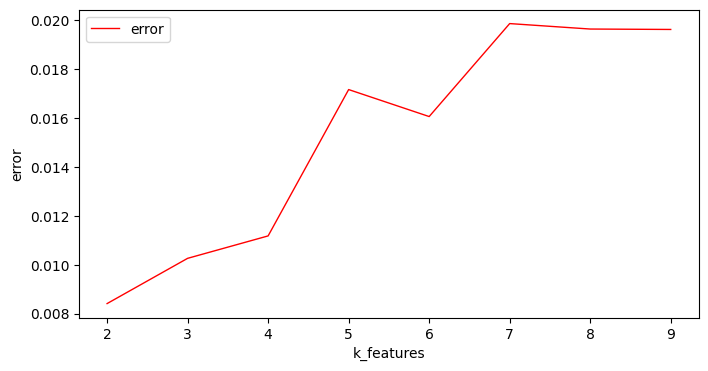

最佳 k 值: 7，最大轮廓系数: 0.0199


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def find_best_K(X):
    """测试选择最优参数"""
    # dataset = loadDataset()
    # print("%d documents" % len(dataset))
    # X, vectorizer = transform(dataset, n_features=500)
    scores = []
    k_values = range(2, 10)
    for k in k_values:
        km = KMeans(
            n_clusters=k,
            init="k-means++",
            max_iter=300,
            verbose=False,
            random_state=42,
        )
        # 聚类数；初始中心选择方法；最大迭代次数；不显示迭代详细日志；固定随机数
        cluster_labels = km.fit_predict(X)
        # 每一个样本被分配到的K
        silhouette_avg = silhouette_score(X, cluster_labels)
        # 计算轮廓系数:轮廓系数𝑠(𝑖)值越接近1表示样本𝑖聚类越合理
        scores.append(silhouette_avg)
    # plt.figure(figsize=(8, 4))
    # plt.plot(k_values, scores, label="error", color="red", linewidth=1)
    # plt.xlabel("k_features")
    # plt.ylabel("error")
    # plt.legend()
    # plt.show()

    # 找到最佳 k
    best_k = k_values[np.argmax(scores)]
    # 返回最优k；np.argmax是最大值的索引
    print(f"最佳 k 值: {best_k}，最大轮廓系数: {max(scores):.4f}")
    return best_k


final_k = find_best_K(X)

输出主题词

In [18]:
km = KMeans(
    n_clusters=final_k,
    init="k-means++",
    max_iter=300,
    verbose=False,
    random_state=42,
)
cluster_labels = km.fit_predict(X)
# 所有样本所属的簇
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# 每个簇的中心点：相对于所有特征的均值（相对于词袋）
# 每一行表示一个簇的中心点，即该簇所有样本在每个特征维度（单词）的均值 从大到小排列，值为其序号
feature_words = vectorizer.get_feature_names_out()

for i in range(final_k):
    print("Topic %d:" % i, end="")
    # 输出前十个特征词[第i个簇,前十个特征索引]
    for ind in order_centroids[i, :10]:
        print(" %s" % feature_words[ind], end="")
    print("\n")

Topic 0: design data study tools user studies space automated knowledge interaction

Topic 1: data analysis task models bars uncertainty encoding storytelling tools natural

Topic 2: perception color graphical visual data cognition analysis encoding image evaluation

Topic 3: learning deep machine data analysis model design reinforcement extraction informal

Topic 4: visual analytics analysis data interaction user immersive evaluation task study

Topic 5: information evaluation uncertainty network data analysis interaction graph chart multi

Topic 6: reality virtual augmented displays immersive dimensional entry interaction analytics mixed



In [29]:
from sklearn.metrics import euclidean_distances

# 计算所有样本到簇中心的距离    sample1:[dis cluster1,dis cluster2 ,...]
distances = euclidean_distances(X, km.cluster_centers_)

# 获取每个簇中离中心最近的样本索引
closest_samples = np.argmin(distances, axis=0)

# 存储每个簇最具代表性的 5 个样本
topic_top_nodes = {}

for cluster in range(final_k):
    # 找出属于当前簇的样本索引
    cluster_indices = np.where(cluster_labels == cluster)[0]

    # 按照距离从小到大排序
    sorted_indices = cluster_indices[np.argsort(distances[cluster_indices, cluster])]

    # 取前 5 个最接近中心的样本
    top_5_indices = sorted_indices[:5]

    # 存储结果
    ls=[]
    for i in range(5):
        ls.append(paperNodes[10][top_5_indices[i]]["ab"])
    topic_top_nodes[cluster] = ls

# 输出每个簇的最近样本
print(len(topic_top_nodes[0]))

KeyboardInterrupt: 